In [ ]:
# !pip install matplotlib
# !pip install pandas

In [2]:
import os
import json

ablations_dir = input("Enter the path to the ablations directory: ")

# a line separated list of ids of the contaminated examples (can be generated from bff outputs by grepping for -Ev '"bff_duplicate_spans":\[\]')
contaminated_ids = [line.strip() for line in open(os.path.join(ablations_dir, "ppl_v2_small_val_contam_ids.txt"))]
assert len(contaminated_ids) == len(set(contaminated_ids))
contaminated_ids = set(contaminated_ids)

# the catwalk "prediction.jsonl" outputs
predictions_baseline = [json.loads(line) for line in open(os.path.join(ablations_dir, "predictions/rp_v1_small.jsonl"))]
predictions_decon = [json.loads(line) for line in open(os.path.join(ablations_dir, "predictions/abl-paragraph-decon.jsonl"))]
predictions = {"rp-v1-small": predictions_baseline, "abl-paragraph-decon": predictions_decon}

<Axes: title={'center': 'Perplexity of the validation set'}>

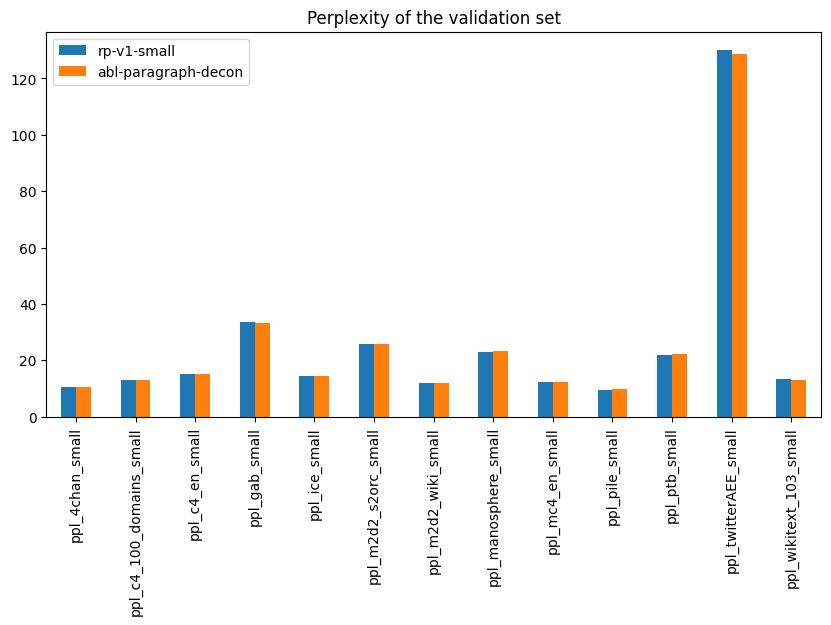

In [14]:
import pandas as pd

all_eval = {
    run_name:{domain['task']:domain['metrics']['ppl_metrics']['ppl_token'] for domain in run}
    for run_name, run in predictions.items() 
}

df_eval = pd.DataFrame(all_eval).T

df_eval.T.plot.bar(figsize=(10, 5), title="Perplexity of the validation set")


<Axes: title={'center': 'Ratio of tokens and docs contaminated'}>

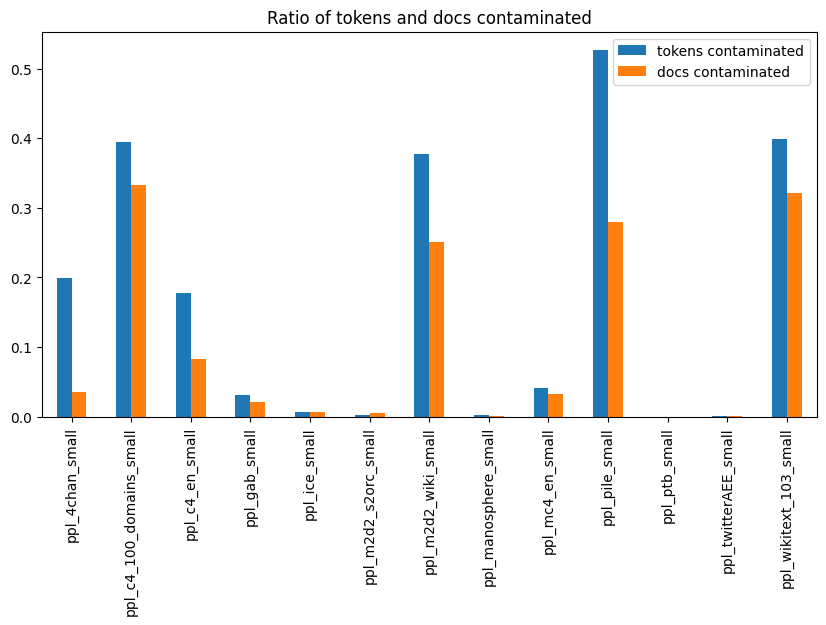

In [42]:
def tokens_contamianted(per_instance, contaminated_ids):
    num_tokens = 0
    total_tokens = 0
    for instance in per_instance:
        total_tokens += instance['prediction']['model_output']['num_tokens']
        if instance['instance']['id'] not in contaminated_ids:
            continue
        num_tokens += instance['prediction']['model_output']['num_tokens']
    return num_tokens / total_tokens

def docs_contamianted(per_instance, contaminated_ids):
    num_docs = 0
    total_docs = 0
    for instance in per_instance:
        total_docs += 1
        if instance['instance']['id'] not in contaminated_ids:
            continue
        num_docs += 1
    return num_docs / total_docs


# recompute ppl_token for just the contaminated ids
tokens_contam = {
    run_name + ' tokens contaminated':{
        domain['task']:tokens_contamianted(domain['per_instance'], contaminated_ids)
        for domain in run
    }
    for run_name, run in predictions.items()
}

assert all(domain1 == domain2 for domain1, domain2 in zip(tokens_contam['rp-v1-small tokens contaminated'].values(), tokens_contam['abl-paragraph-decon tokens contaminated'].values()))

# recompute ppl_token for just the contaminated ids
docs_contam = {
    run_name + ' docs contaminated':{
        domain['task'] :docs_contamianted(domain['per_instance'], contaminated_ids)
        for domain in run
    }
    for run_name, run in predictions.items()
}

assert all(domain1 == domain2 for domain1, domain2 in zip(docs_contam['rp-v1-small docs contaminated'].values(), docs_contam['abl-paragraph-decon docs contaminated'].values()))


# merge first row from each dict
docs_and_tokens_contam = {'tokens contaminated':{**tokens_contam['rp-v1-small tokens contaminated']}, 'docs contaminated':{**docs_contam['rp-v1-small docs contaminated']}}
df_docs_and_tokens_contam = pd.DataFrame(docs_and_tokens_contam).T

df_docs_and_tokens_contam.T.plot.bar(figsize=(10, 5), title="Ratio of tokens and docs contaminated")
# 

<Axes: title={'center': 'Perplexity of just contaminated eval docs'}>

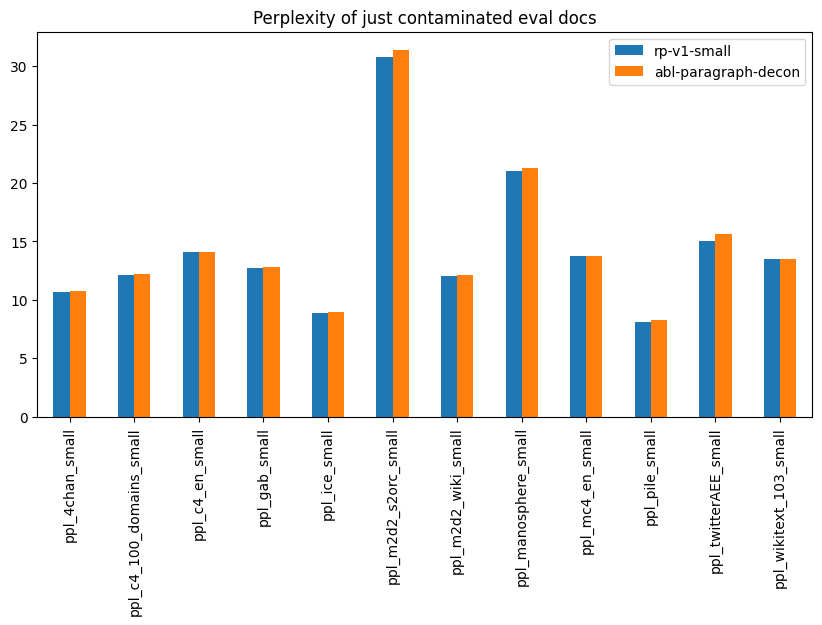

In [63]:
import math

def safe_exp(x):
    try:
        ans = math.exp(x)
    except OverflowError:
        ans = 1e30
    return ans

def recompute_ppl_token(per_instance, contaminated_ids):
    sum_logits = 0
    num_tokens = 0
    for instance in per_instance:
        if instance['instance']['id'] not in contaminated_ids:
            continue
        sum_logits += instance['prediction']['model_output']['sum_logits']
        num_tokens += instance['prediction']['model_output']['num_tokens']
    if num_tokens == 0:
        return None
    return safe_exp(-sum_logits / num_tokens)


# recompute ppl_token for just the contaminated ids
contam_eval = {
    run_name:{
        domain['task']:recompute_ppl_token(domain['per_instance'], contaminated_ids)
        for domain in run if recompute_ppl_token(domain['per_instance'], contaminated_ids) is not None
    }
    for run_name, run in predictions.items()
}

df_contam_eval = pd.DataFrame(contam_eval).T

df_contam_eval.T.plot.bar(figsize=(10, 5), title="Perplexity of just contaminated eval docs")




In [62]:
df_all = pd.concat([df_contam_eval, df_docs_and_tokens_contam])
df_all = df_all.round(2)
df_all

,ppl_4chan_small,ppl_c4_100_domains_small,ppl_c4_en_small,ppl_gab_small,ppl_ice_small,ppl_m2d2_s2orc_small,ppl_m2d2_wiki_small,ppl_manosphere_small,ppl_mc4_en_small,ppl_pile_small,ppl_twitterAEE_small,ppl_wikitext_103_small,ppl_ptb_small
rp-v1-small,10.67,12.16,14.12,12.69,8.86,30.82,12.04,21.04,13.76,8.06,15.04,13.48,NaN
abl-paragraph-decon,10.76,12.22,14.13,12.84,8.99,31.38,12.10,21.27,13.78,8.31,15.63,13.47,NaN
tokens contaminated,0.20,0.39,0.18,0.03,0.01,0.00,0.38,0.00,0.04,0.53,0.00,0.40,0.0
docs contaminated,0.04,0.33,0.08,0.02,0.01,0.00,0.25,0.00,0.03,0.28,0.00,0.32,0.0
